# Cosponsorship analysis 

This notebook aims to
1. get sponsorship and cosponsorship information from bills voted by the 115th senate

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import requests
import seaborn as sns

In [2]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
VOTES_115 = '../data/all-votes/votes_115.csv'
API_KEY = 'EaNt0652GV92i9U9Mlhs0ggCwLPyRB23bc6qAeyX'


In [129]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
bills_115 = all_laws[(all_laws['congress'] == 115) & (all_laws['bill_api_uri'].notnull())]
bills_111 = all_laws[(all_laws['congress'] == 111) & (all_laws['bill_api_uri'].notnull())]

In [130]:
bills_115_ = bills_115['bill_api_uri'].unique()
bills_111_ = bills_111['bill_api_uri'].unique()

In [5]:
# bills_115_names = [i.split('/')[7].split('.')[0] for i in bills_115['bill_api_uri'].unique()]

In [5]:
bills_sponsorship_115 = []

for i in range(0, len(bills_115_)):
    url = bills_115_[i][:-5] + '/cosponsors.json'
    
    d = {}
    try:
        req = requests.get(url, headers={'X-API-Key': API_KEY}).json()
        results = req['results'][0]
        d['bill_url'] = bills_115_[i]
        d['sponsor_party'] = results['sponsor_party']
        d['sponsor_id'] = results['sponsor_id']
        d['sponsor_title'] = results['sponsor_title']
        d['committees'] = results['committees']
        d['number_of_cosponsors'] = results['number_of_cosponsors']
        d['cosponsors_by_party'] = results['cosponsors_by_party']
        d['cosponsors'] = results['cosponsors']

        bills_sponsorship_115.append(d)
    except:
        pass
    

In [6]:
bills_sponsorship_111 = []

for i in range(0, len(bills_111_)):
    url = bills_111_[i][:-5] + '/cosponsors.json'
    
    d = {}
    try:
        req = requests.get(url, headers={'X-API-Key': API_KEY}).json()
        results = req['results'][0]
        d['bill_url'] = bills_111_[i]
        d['sponsor_party'] = results['sponsor_party']
        d['sponsor_id'] = results['sponsor_id']
        d['sponsor_title'] = results['sponsor_title']
        d['committees'] = results['committees']
        d['number_of_cosponsors'] = results['number_of_cosponsors']
        d['cosponsors_by_party'] = results['cosponsors_by_party']
        d['cosponsors'] = results['cosponsors']

        bills_sponsorship_111.append(d)
    except:
        pass
    

In [80]:
bills_sponsorship_115 = pd.DataFrame(bills_sponsorship_115)
bills_sponsorship_111 = pd.DataFrame(bills_sponsorship_111)

In [131]:
bills_115 = bills_115.merge(bills_sponsorship_115, left_on = 'bill_api_uri', right_on = 'bill_url')
bills_111 = bills_111.merge(bills_sponsorship_111, left_on = 'bill_api_uri', right_on = 'bill_url')

In [132]:
LOOKUP_RESULT = {
'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected',
'Joint Resolution Passed': 'passed', 'Concurrent Resolution Agreed to': 'passed', 'Motion to Proceed Rejected': 'rejected', 
'Motion to Discharge Rejected': 'rejected', 'Conference Report Agreed to': 'passed', 'Resolution Agreed to': 'passed', 
'Motion to Adjourn Rejected': 'rejected', 'Motion for Attendance Agreed to': 'passed', 'Motion to Discharge Agreed to': 'passed',
'Motion to Table Failed': 'rejected', 'Joint Resolution Defeated': 'rejected', 'Motion to Adjourn Agreed to': 'passed', 'Point of Order Not Sustained': 'rejected'}
bills_115['result_ok'] = bills_115.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefined'))
bills_111['result_ok'] = bills_111.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefined'))

### Get status of votes according to sponsor party:

In [133]:
bills_115 = bills_115[bills_115['result_ok'].isin(['passed', 'rejected'])]
bills_111 = bills_111[bills_111['result_ok'].isin(['passed', 'rejected']) & (bills_111['sponsor_id'] !='')]

In [134]:
bills_111.sponsor_party = bills_111.sponsor_party.replace({'ID': 'D'}) # We'll consider Independent - Democrat = Democrat

In [135]:
N_BILLS_115 = len(bills_115.bill_api_uri.unique())
N_BILLS_111 = len(bills_111.bill_api_uri.unique())

Text(0.5,1,'Senate 111')

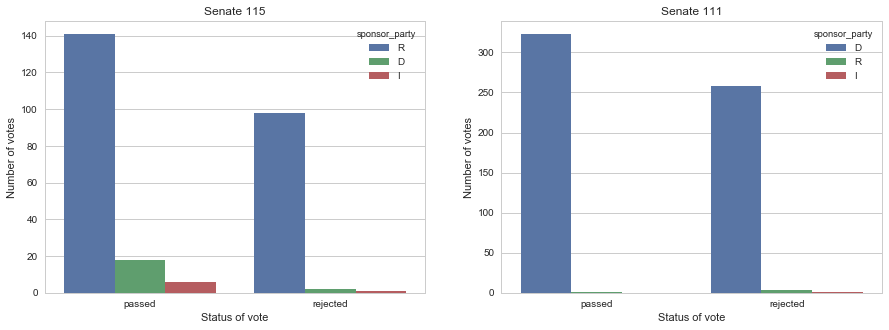

In [161]:
fig, ax = plt.subplots(1,2,figsize = (15, 5))
sns.set(style="whitegrid")
sns.countplot(x="result_ok", ax = ax[0], hue = "sponsor_party", data= bills_115)
ax[0].set_ylabel('Number of votes');
ax[0].set_xlabel('Status of vote');
ax[0].set_title('Senate 115')
sns.countplot(x="result_ok", ax = ax[1], hue = "sponsor_party", data= bills_111)
ax[1].set_ylabel('Number of votes');
ax[1].set_xlabel('Status of vote');
ax[1].set_title('Senate 111')

### Get status of votes according to number of cosponsor for each party:

In [144]:
bills_115.cosponsors_by_party.iloc[28]

[{'party': {'id': 'D', 'sponsors': '1'}},
 {'party': {'id': 'R', 'sponsors': '119'}}]

In [146]:
def get_nb_cosponsors(bills):
    bills['nb_cosponsors_R']=0
    bills['nb_cosponsors_D']=0
    bills['nb_cosponsors_I']=0

    for i in range(len(bills)):
        if bills.number_of_cosponsors.iloc[i]:
            for item in bills.cosponsors_by_party.iloc[i]:
                if item['party']['id'] !='ID':
                    bills['nb_cosponsors_'+item['party']['id']].iloc[i]= int(item['party']['sponsors'])
                else:
                    bills['nb_cosponsors_D'].iloc[i]+= int(item['party']['sponsors'])
    return bills

In [147]:
bills_115 = get_nb_cosponsors(bills_115)
bills_111 = get_nb_cosponsors(bills_111)

In [148]:
bills_115=bills_115.drop(['result','total_no', 'total_not_voting', 'total_yes', 'cosponsors_by_party','number_of_cosponsors','congress'], axis=1)
bills_111=bills_111.drop(['result','total_no', 'total_not_voting', 'total_yes', 'cosponsors_by_party','number_of_cosponsors','congress'], axis=1)

In [150]:
bills_115.columns

Index(['bill_api_uri', 'date', 'democrats_no', 'democrats_yes',
       'independent_no', 'independent_yes', 'month', 'republican_no',
       'republican_yes', 'vote_type', 'vote_uri', 'year', 'bill_url',
       'committees', 'cosponsors', 'sponsor_id', 'sponsor_party',
       'sponsor_title', 'result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D',
       'nb_cosponsors_I'],
      dtype='object')

In [154]:
def get_cosponsors_idx(bills):
    bills['cosponsors_sen'] = ''
    bills['cosponsors_rep'] = ''
    bills['cosponsors_del'] = ''

    for i in range(len(bills)):
        cosponsors_list_sen = []
        cosponsors_list_rep = []
        cosponsors_list_del = []
        for j in range(len(bills.cosponsors.iloc[i])):
            if bills.cosponsors.iloc[i][j]['cosponsor_title'] == 'Sen.':
                cosponsors_list_sen.append(bills.cosponsors.iloc[i][j]['cosponsor_id'])
            elif bills.cosponsors.iloc[i][j]['cosponsor_title'] == 'Rep.':
                cosponsors_list_rep.append(bills.cosponsors.iloc[i][j]['cosponsor_id'])
            elif bills.cosponsors.iloc[i][j]['cosponsor_title'] == 'Del.':
                cosponsors_list_del.append(bills.cosponsors.iloc[i][j]['cosponsor_id'])
        bills.cosponsors_sen.iloc[i] = cosponsors_list_sen
        bills.cosponsors_rep.iloc[i] = cosponsors_list_rep
        bills.cosponsors_del.iloc[i] = cosponsors_list_del
    
    return bills

In [156]:
bills_115 = get_cosponsors_idx(bills_115)
bills_111 = get_cosponsors_idx(bills_111)

In [158]:
bills_115 = bills_115.drop('cosponsors', axis = 1)
bills_111 = bills_111.drop('cosponsors', axis = 1)

In [159]:
aux_data_115 = pd.melt(bills_115.loc[:,['result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']], id_vars="result_ok", var_name="party", value_name="cosponsors_nb")
aux_data_115.party = aux_data_115.party.map({'nb_cosponsors_R': 'R', 'nb_cosponsors_D':'D', 'nb_cosponsors_I':'I'})
aux_data_111 = pd.melt(bills_111.loc[:,['result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']], id_vars="result_ok", var_name="party", value_name="cosponsors_nb")
aux_data_111.party = aux_data_111.party.map({'nb_cosponsors_R': 'R', 'nb_cosponsors_D':'D', 'nb_cosponsors_I':'I'})

Text(0.5,1,'Senate 111')

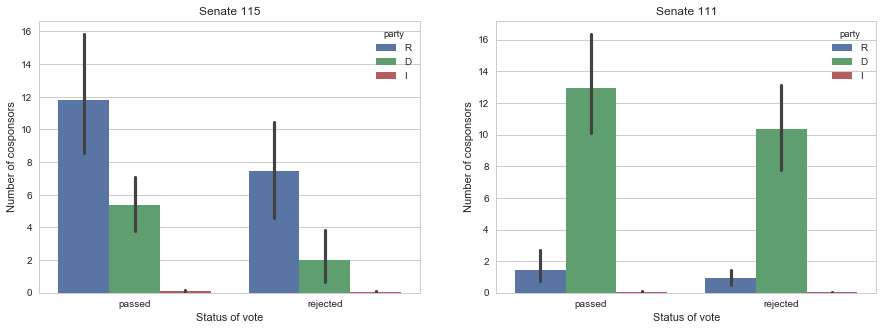

In [163]:
fig, ax = plt.subplots(1,2,figsize = (15, 5))
sns.barplot(x='result_ok', y='cosponsors_nb', ax = ax[0], hue='party', data=aux_data_115)
ax[0].set_ylabel('Number of cosponsors');
ax[0].set_xlabel('Status of vote');
ax[0].set_title('Senate 115')
sns.barplot(x='result_ok', y='cosponsors_nb', ax = ax[1], hue='party', data=aux_data_111)
ax[1].set_ylabel('Number of cosponsors');
ax[1].set_xlabel('Status of vote');
ax[1].set_title('Senate 111')


### Evaluate proportion of senators sponsoring bills:

In [165]:
print('Senate 115: {0:0.2f}% of the bill sponsors are part of the senate.'.format(100*sum([bills_115[bills_115.sponsor_id == i].sponsor_title.iloc[0]=='Sen.' for i in bills_115.sponsor_id.unique()])/len(bills_115.sponsor_id.unique())))
print('Senate 111: {0:0.2f}% of the bill sponsors are part of the senate.'.format(100*sum([bills_111[bills_111.sponsor_id == i].sponsor_title.iloc[0]=='Sen.' for i in bills_111.sponsor_id.unique()])/len(bills_111.sponsor_id.unique())))

Senate 115: 38.18% of the bill sponsors are part of the senate.
Senate 111: 38.46% of the bill sponsors are part of the senate.


In [166]:
def get_cosponsors_ids(bills):
    cosponsors_sen_ids=[]
    cosponsors_rep_ids=[]

    for i, j in enumerate(bills.cosponsors_sen):
        cosponsors_sen_ids = cosponsors_sen_ids + bills.cosponsors_sen.iloc[i]
        cosponsors_rep_ids = cosponsors_rep_ids + bills.cosponsors_rep.iloc[i]

    cosponsors_rep_ids=list(set(cosponsors_rep_ids))
    cosponsors_sen_ids=list(set(cosponsors_sen_ids))
    cosponsors_ids = cosponsors_sen_ids + cosponsors_rep_ids
    return cosponsors_rep_ids, cosponsors_sen_ids, cosponsors_ids

In [168]:
_, cosponsors_sen_ids_115, cosponsors_ids_115 = get_cosponsors_ids(bills_115)
_, cosponsors_sen_ids_111, cosponsors_ids_111 = get_cosponsors_ids(bills_111)

In [169]:
print('Senate 115: {0:0.2f}% of the bill cosponsors are part of the senate'.format(100*len(cosponsors_sen_ids_115)/len(cosponsors_ids_115)))
print('Senate 111: {0:0.2f}% of the bill cosponsors are part of the senate'.format(100*len(cosponsors_sen_ids_111)/len(cosponsors_ids_111)))

Senate 115: 23.45% of the bill cosponsors are part of the senate
Senate 111: 19.73% of the bill cosponsors are part of the senate


### Influence of sponsor title:

In [180]:
bills_111.sponsor_title = bills_111.sponsor_title.replace({'': 'Rep.'})  # Empty sponsor title = Representative (Nancy Pelosi)

Text(0.5,1,'Senate 111')

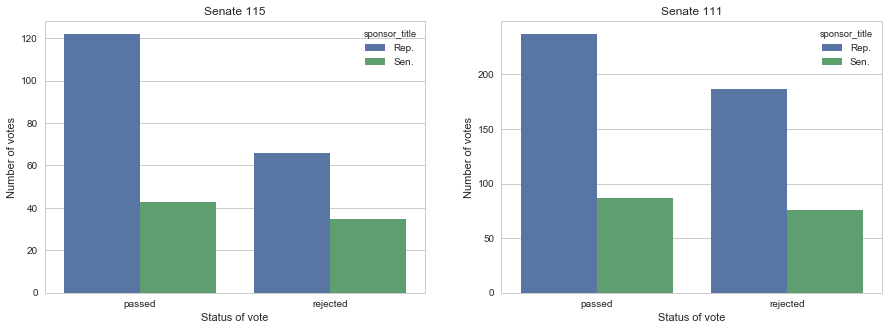

In [181]:
fig, ax = plt.subplots(1,2,figsize = (15, 5))
sns.countplot(x='result_ok', ax = ax[0], hue='sponsor_title', data=bills_115)
ax[0].set_ylabel('Number of votes');
ax[0].set_xlabel('Status of vote');
ax[0].set_title('Senate 115')
sns.countplot(x='result_ok', ax = ax[1], hue='sponsor_title', data=bills_111)
ax[1].set_ylabel('Number of votes');
ax[1].set_xlabel('Status of vote');
ax[1].set_title('Senate 111')


### Influence of cosponsors title:

In [183]:
def get_nb_cosponsor_per_vote(bills):
    aux_sen=[]
    aux_rep=[]

    for i, j in enumerate(bills.cosponsors_sen):
        aux_sen.append(len(bills.cosponsors_sen.iloc[i]))
        aux_rep.append(len(bills.cosponsors_rep.iloc[i]))
    return aux_sen, aux_rep

In [186]:
aux_sen_115 , aux_rep_115 = get_nb_cosponsor_per_vote(bills_115)
aux_data_115_ = pd.DataFrame(bills_115['result_ok']).join(pd.DataFrame(data=np.array([aux_rep_115, aux_sen_115]).T, index=bills_115.index, columns=['n_rep', 'n_sen']))
aux_data_115_ = pd.melt(aux_data_115_, id_vars="result_ok", var_name="title", value_name="cosponsors_nb")

aux_sen_111 , aux_rep_111 = get_nb_cosponsor_per_vote(bills_111)
aux_data_111_ = pd.DataFrame(bills_115['result_ok']).join(pd.DataFrame(data=np.array([aux_rep_111, aux_sen_111]).T, index=bills_111.index, columns=['n_rep', 'n_sen']))
aux_data_111_ = pd.melt(aux_data_111_, id_vars="result_ok", var_name="title", value_name="cosponsors_nb")

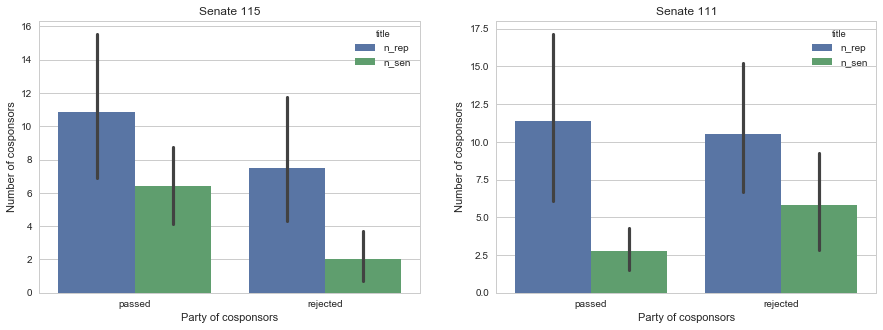

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='result_ok', y='cosponsors_nb', ax = ax[0], hue='title', data=aux_data_115_)
ax[0].set_ylabel('Number of cosponsors');
ax[0].set_xlabel('Party of cosponsors');
ax[0].set_title('Senate 115');


sns.barplot(x='result_ok', y='cosponsors_nb', ax = ax[1], hue='title', data=aux_data_111_)
ax[1].set_ylabel('Number of cosponsors');
ax[1].set_xlabel('Party of cosponsors');
ax[1].set_title('Senate 111');




### Cosponsors profile Senate 115

In [195]:
aux_data1=bills_115.loc[:,['result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']].join(pd.DataFrame(data=np.array([aux_rep_115,aux_sen_115]).T, index=bills_115.index, columns=['n_rep', 'n_sen']))

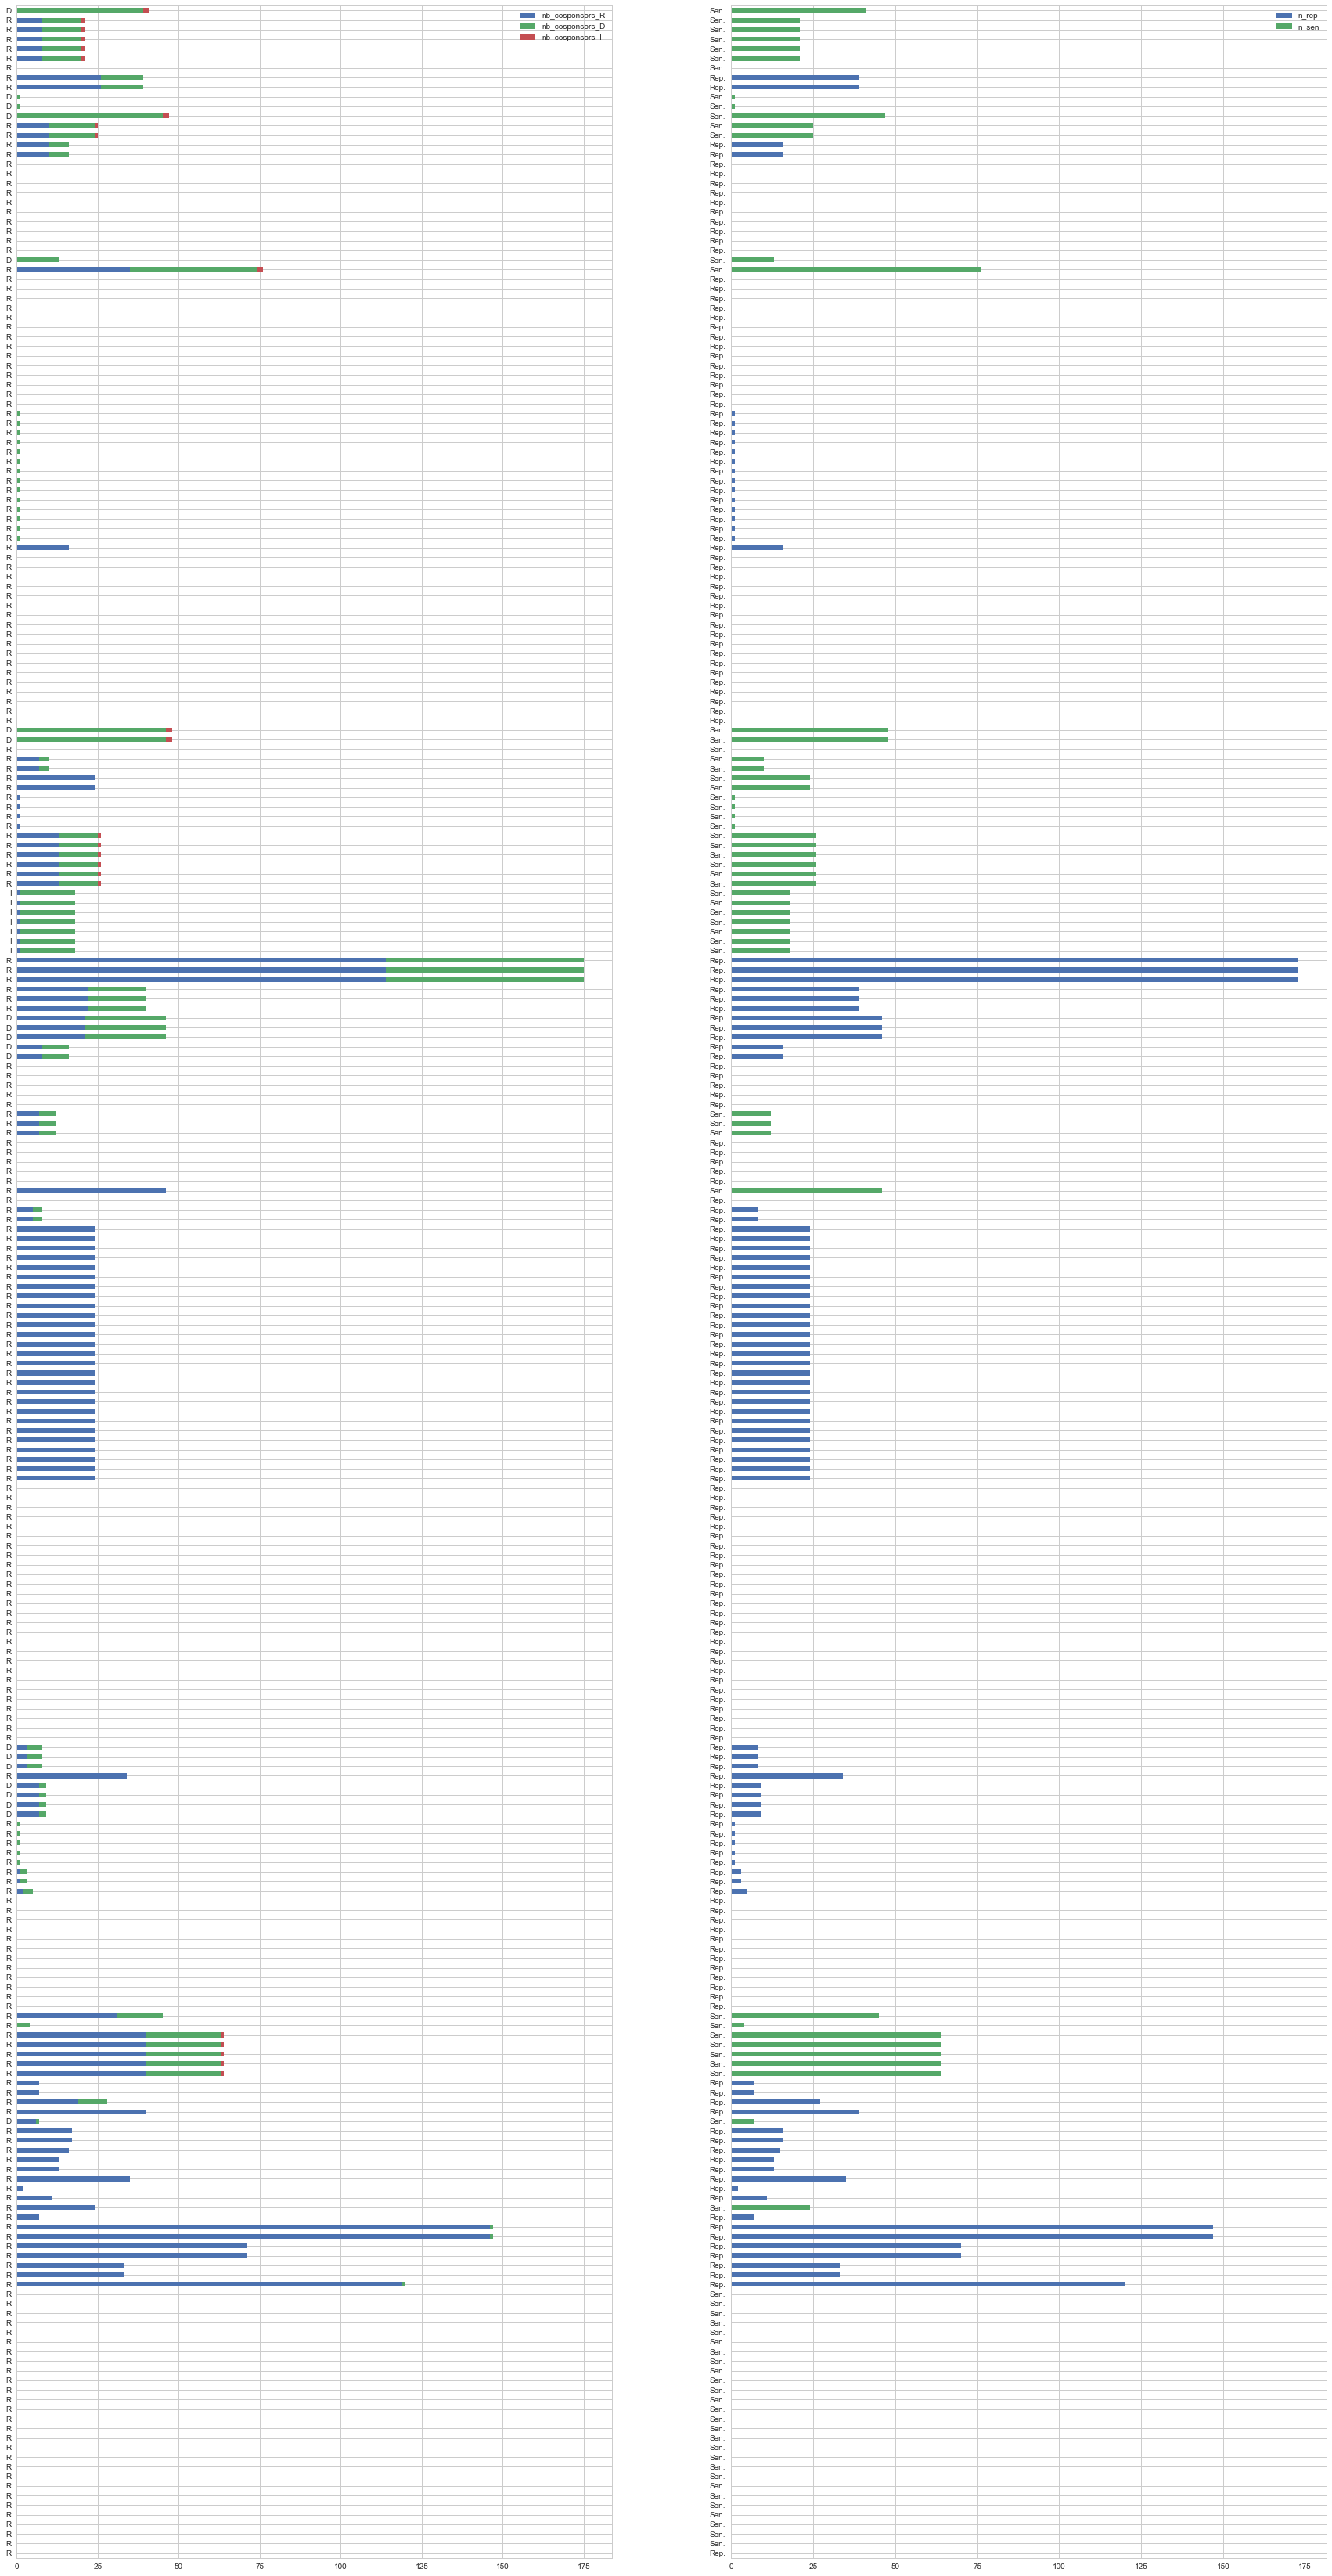

In [196]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(30,60))
aux_data1.loc[:,['nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']].plot(ax = ax1,kind='barh', stacked = True)
aux_data1.loc[:,['n_rep', 'n_sen']].plot(ax=ax2,kind='barh', stacked = True)
ax2.set_yticklabels(bills_115['sponsor_title']);
ax1.set_yticklabels(bills_115['sponsor_party']);

Note:
- The sponsor and cosponsors titles must be the same;
- 38% of the bills are sponsored by a senator, most of them republicans.
- Bills proposed by Democrats appear to pass with higher probability;
- Bills proposed by a member of the House of Representatives pass with higher probability than bills proposed by a member of the Senate (probably because it has already passed in the HoR).
- Bills with higher number of senators cosponsors appear to pass with higher probability.

In [31]:
# bills_115.to_csv('../data/bills_115.csv')

In [201]:
# bills_111.to_csv('../data/bills_111.csv')

## Get votes senate 111

In [204]:
votes111 = list(all_laws[all_laws.congress == 111]['vote_uri'])

df = pd.DataFrame()

for i, url in enumerate(votes111):
    req = requests.get(url, headers={'X-API-Key': API_KEY}).json()
    d = pd.DataFrame(req['results']['votes']['vote']['positions'])
    d['vote_uri'] = url
    
    df = pd.concat([df, d])
    
# df.to_csv('../data/votes_111.csv', index=False)